In [1]:
import state_utils

from numba import jit,njit 
import state_utils

state_utils.set_cohort("Poyet")
state_utils.set_host("am")
state_utils.set_midas_db_type("standard")


import pandas as pd
import numpy as np
import time
from scipy.stats import gamma
import config
import slm_utils
from scipy.stats import chisquare
from parse_midas_data import parse_good_species_list
import sys

import matplotlib.pyplot as plt

In [29]:
## calculates the chi-squared test statistic for the goodness of fit test
def calc_chisq(obs_data,dates_diff,train_num):
    
    ## fit the SLM on the first train_num observations
    params = slm_utils.fit_SLM_params(obs_data,n=train_num)

    ## initialize SLM 
    S = slm_utils.slm(sigma=params["sigma"],K=params["K"],tau=1,delta_t=1.0/100)

    ## form quin_bins number of bins, expect to have 5 (= 4 + 1) observations in each bin, per recommendations re: chisquare test
    ## https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html
    quin_bins = len(obs_data)//4
    
    bin_list = []
    
    ## get bin of initial value w/r/t stationary distribution
    init_bin = int(np.digitize(obs_data.iloc[train_num],S.afd.ppf(np.linspace(0,100,quin_bins + 2)/100)[1:])) - 1
    bin_list.append(init_bin)
    
    ## now get bins of all subsequent timepoints 
    ## essentially, build an empirical probability distribution for abundance at time t + delta_t given abundance at t
    ## then, figure out which quintile bin of this empirical distribution the actual observation lies in
    for i in range(train_num,len(obs_data) - 1):
        
        T = dates_diff[i+1]
        num_iters = int(1.0*T/(1.0*S.delta_t))

        init_val = obs_data.iloc[i]
        num_reps = 10000
        S.set_init_val(obs_data.iloc[i])
        S.run_sim(num_iters,num_reps,record_steps=False)

        bin_list.append(np.digitize(obs_data.iloc[i+1],np.percentile(S.x_i,np.linspace(0,100,quin_bins))))
    
    ## calculate chisquare test statistic relative to uniform expectation
    return chisquare(np.unique(bin_list,return_counts=True)[1])[1]  


In [25]:
quin_bins = len(obs_data)//10
quin_bins

19

In [26]:
data_dir=config.data_directory

strain_df = pd.read_csv("strains_%s.csv"%config.host,index_col=0)
strain = strain_df.index[-1]

species = strain[:-2]

chisq_dic = {}

good_samples = pd.read_csv("%s/snps/%s/snps_summary.txt" % (data_dir,species),index_col=0,sep="\t").index
sys.stderr.write("Processing %s \n" % species)
obs_data = strain_df.loc[strain]

obs_data = obs_data[good_samples]
obs_data = obs_data[obs_data.notna()]
if len(obs_data) > 25:
    strain_dates = config.dates.loc[obs_data.index].sort_values()

    ## be sure observed data is in correct chronological order                
    obs_data = obs_data.loc[strain_dates.index]
    strain_dates_diff = strain_dates.diff()
    train_num = len(obs_data)//3
    #chisq_dic[strain] = calc_chisq(obs_data,strain_dates_diff,train_num)
    chisq_dic[strain] = [calc_chisq(obs_data,strain_dates_diff,train_num) for _ in range(100)]

Processing Bacteroides_vulgatus_57955 


[]

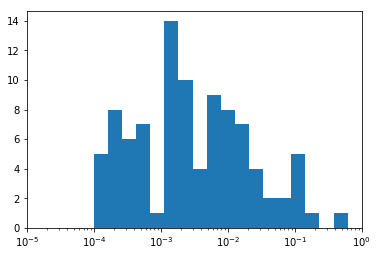

In [27]:
plt.hist(chisq_dic['Bacteroides_vulgatus_57955_C'],bins=np.logspace(-4,0,20))
plt.xlim([1e-5,1]);
plt.semilogx()

In [ ]:
plt.plot(strain_dates.values,obs_data.values)
plt.axvline(strain_dates.values[train_num])

In [ ]:
train_num

In [28]:
np.median(chisq_dic['Bacteroides_vulgatus_57955_C'])

0.002128217629694091